In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [132]:
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (12,7)

In [133]:
df = pd.read_csv('/Users/hsoekiswo/Documents/Present Projects/eFishery/Deep Analysis/Survey Marketing/200514 - Survey Konsumen.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [134]:
df['Timestamp'].count()

127

Survey hanya diisi oleh 127 responden, hampir sepertiga dari jumlah responden survey sebelumnya. Apakah ini masih bisa diandalkan sebagai insight? Atau perlu digabung dengan hasil survey sebelumnya?

Tapi bagaimana cara menggabungkan dengan data sebelumnya tanpa duplikasi?

# Demografi

In [135]:
jabodetabek = [
    'dki jakarta',
    'bogor',
    'depok',
    'tangerang',
    'bekasi'
]

conditions = [
    df['Domisili (kota/kabupaten)'].str.lower().isin(jabodetabek),
    df['Domisili (kota/kabupaten)'].str.lower() == 'bandung '
]

choices = [
    'jabodetabek',
    'bandung'
]

df['domisili'] = np.select(conditions, choices, default='other')

Sempat cukup lama berkutat pada code di atas, ternyata pada raw data 'Bandung' tertulis dengan 'Bandung ' tertambah spasi. Gimana ya cara identifikasi string yg mirip dengan menggunakan bool? Misal kalau di sql itu `like '%bandung%'`?

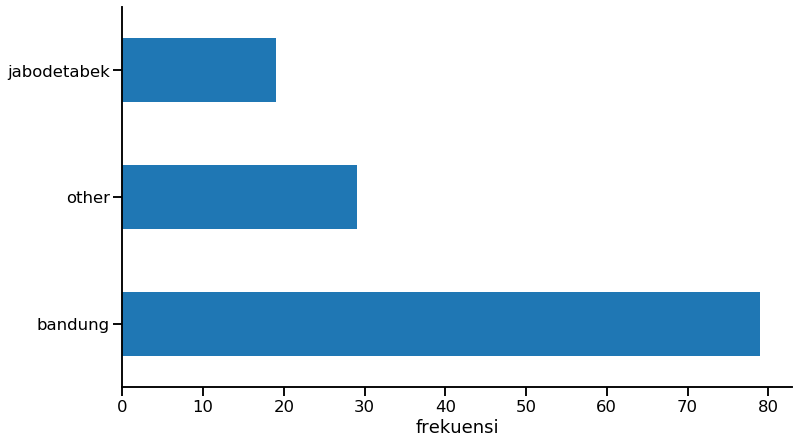

In [146]:
df['domisili'].value_counts().plot.barh()
plt.xlabel('frekuensi')
sns.despine()

Pada hasil eksplorasi data survey sebelumnya dikatakan bahwa responden >30 dan grouping yang relatif seragam bisa menjadi *magic number* untuk mengesahkan bahwa survey itu representatif. Apakah data dari survey ini bisa representatif? Atau hanya bisa memperdalam analisa wilayah Bandung?

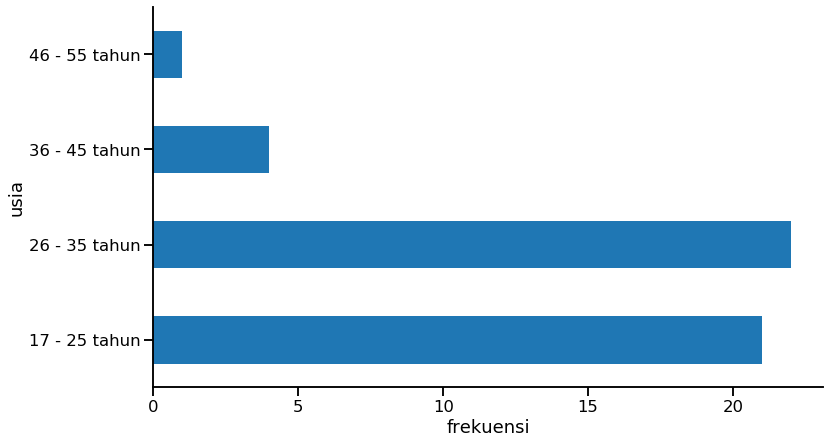

In [137]:
df.loc[df['domisili'] != 'bandung','Usia'].value_counts().sort_index().plot.barh()
plt.xlabel('frekuensi')
plt.ylabel('usia')
sns.despine()

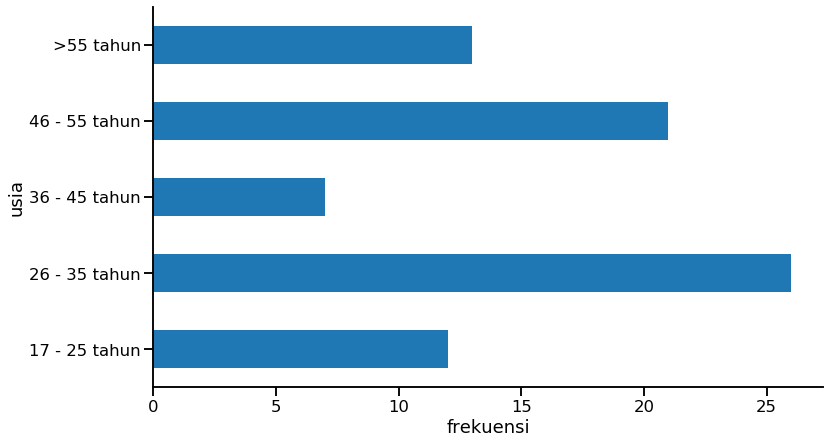

In [138]:
df.loc[df['domisili'] == 'bandung','Usia'].value_counts().sort_index().plot.barh()
plt.xlabel('frekuensi')
plt.ylabel('usia')
sns.despine()

Hal yang menarik disini adalah bahwa responden berdasarkan usia di Bandung lebih seragam dibandingkan pada domisili lainnya maupun dari data survey sebelumnya. Kecuali pada usia 35-45 tahun yang frekuensinya jauh lebih rendah dari kelompok usia lainnya

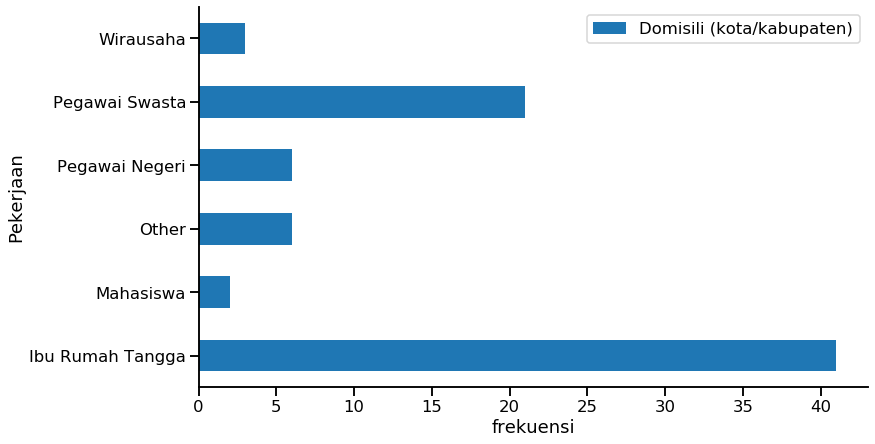

In [139]:
dfb = df.loc[df['domisili'] == 'bandung']
dfb[['Domisili (kota/kabupaten)','Pekerjaan']].groupby('Pekerjaan').count().plot.barh()
plt.xlabel('frekuensi')
sns.despine()

In [140]:
bekerja = [
    'mahasiswa',
    'pegawai negeri',
    'pegawai swasta',
    'wirausaha'
]

conditions = [
    dfb['Pekerjaan'].str.lower().isin(bekerja),
    dfb['Pekerjaan'].str.lower() == 'ibu rumah tangga'
]

choices = [
    'bekerja',
    'ibu rumah tangga'
]

dfb['bekerja'] = np.select(conditions, choices, default='other')

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


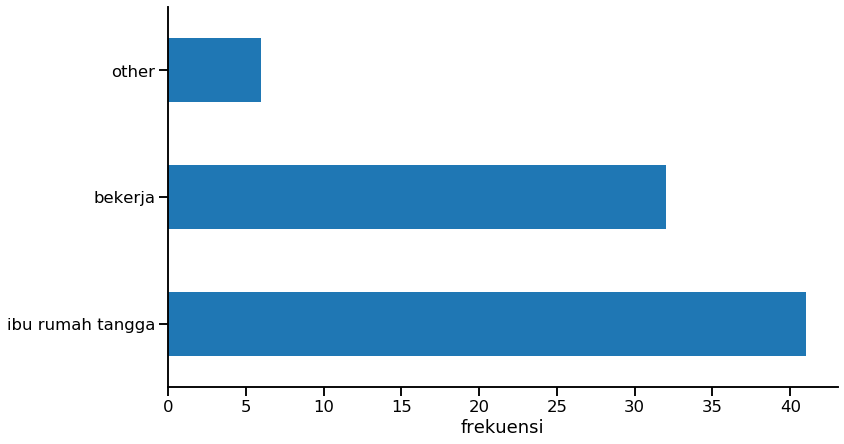

In [141]:
dfb['bekerja'].value_counts().plot.barh()
plt.xlabel('frekuensi')
sns.despine()

Ketika 'Pekerjaan' dibagi menjadi dua golongan antara responden yang bekerja dan ibu rumah tangga, ternyata pambagiannya cukup seimbang. Oleh karena itu saya ingin mencoba mencari tahu lebih dalam tentang perbedaan *behavior* mereka

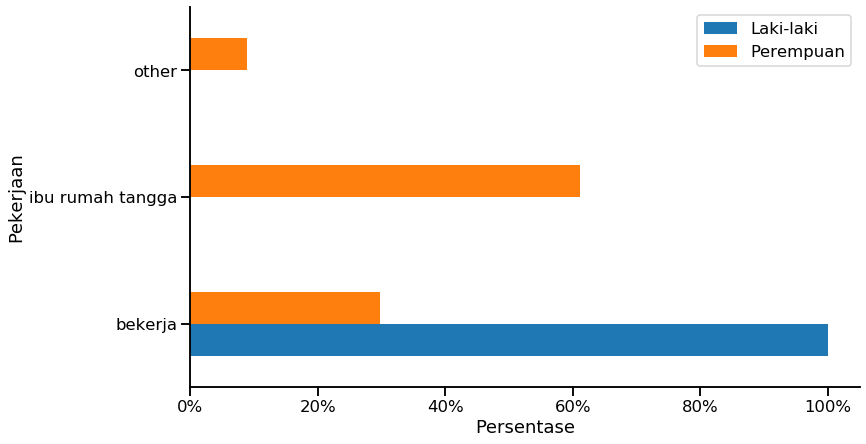

In [142]:
pivoted = dfb.pivot_table(
    values='Usia',
    index='Jenis kelamin',
    columns='bekerja',
    aggfunc='count',
    fill_value=0
)
ax = pivoted.divide(pivoted.sum(axis=1), axis=0).T.plot.barh()
plt.legend()
vals = ax.get_xticks()
ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])
plt.xlabel('Persentase')
plt.ylabel('Pekerjaan')
sns.despine()

In [143]:
expense_cols = [
    '< Rp. 500.000',
    'Rp. 500.000 - Rp. 1.000.000',
    'Rp. 1.000.000 - Rp. 2.500.000',
    'Rp. 2.500.000 - Rp. 5.000.000',
    '> Rp. 5.000.000'
]

In [144]:
dfb[dfb['bekerja'] != 'other'].pivot_table(
    values = 'Jenis kelamin',
    index = ['bekerja', 'Usia'],
    columns = 'Pengeluaran yang Anda keluarkan selama 1 bulan',
    aggfunc = 'count',
    fill_value = 0
)[expense_cols].T.style.background_gradient()

Kalau dari pengeluaran sepertinya tidak terlihat perbedaan yang ekstrim antara responden yang bekerja dengan ibu rumah tangga

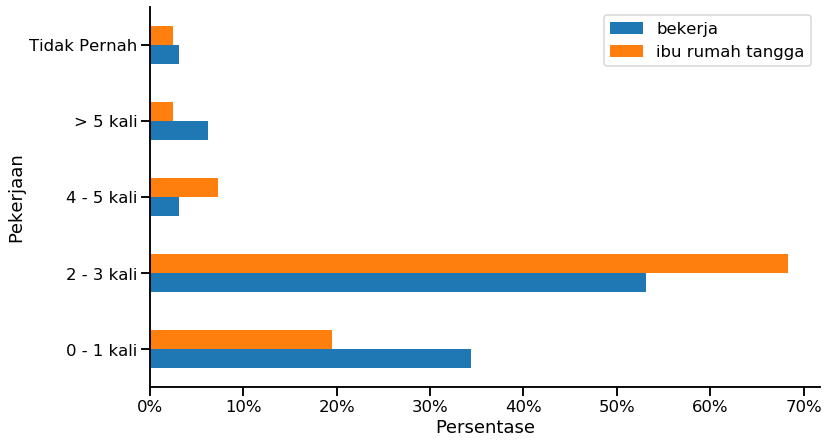

In [209]:
pivoted = dfb[dfb['bekerja'] != 'other'].pivot_table(
    values = 'Jenis kelamin',
    index = 'bekerja',
    columns = 'Dalam seminggu, seberapa sering Anda mengonsumsi Produk Perikanan?',
    aggfunc = 'count',
    fill_value = 0
)
ax = pivoted.divide(pivoted.sum(axis=1), axis=0).T.plot.barh()
plt.legend()
vals = ax.get_xticks()
ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])
plt.xlabel('Persentase')
plt.ylabel('Pekerjaan')
sns.despine()

Lebih dari 30% responden yang bekerja frekuensi makan ikannya 0-1 x seminggu, sedangkan 7 dari 10 ibu rumah tangga makan 2-3 x ikan dalam seminggu.

Apakah perbedaannya signifikan? Beda cuma 1 dan 2-3 kali doang ciaw

Tapi coba kita itung-itung.
0-1x itu rata2 0.5x kan? Sedangkan 2-3x itu berarti 2.5x seminggu.
Kalau ada 100 orang ibu rumah tangga dan 100 orang yg bekerja sebagai target pasar kita berarti:

orang yang bekerja:
    
    35% konsumsi ikan 0-1x: 35% x 0.5 x 100 = 17.5
    50% konsumsi ikan 2-3x: 50% x 2.5 x 100 = 125
    frekuensi konsumsi ikan 17.5 + 125 = 142.5
    
ibu rumah tangga:
    
    20% konsumsi ikan 0-1x: 20% x 0.5 x 100 = 10
    70% konsumsi ikan 2-3x: 70% x 2.5 x 100 = 175
    frekuensi konsumsi ikan 10 + 175 = 185
    
Bedanya ibu rumah tangga 20% lebih sering mengkonsumsi ikan. Lumayan besar perbedaannya.

Apa karena konsumsi ikan itu persiapannya repot dan perlu waktu untuk menyiapkannya?

In [248]:
pengeluaran_tinggi = [
    '> Rp. 5.000.000'
]

pengeluaran_sedang = [
    'Rp. 1.000.000 - Rp. 2.500.000',
    'Rp. 2.500.000 - Rp. 5.000.000'  
]

pengeluaran_rendah = [
    'Rp. 500.000 - Rp. 1.000.000',
    '< Rp. 500.000'
]

conditions = [
    dfb['Pengeluaran yang Anda keluarkan selama 1 bulan'].isin(pengeluaran_tinggi),
    dfb['Pengeluaran yang Anda keluarkan selama 1 bulan'].isin(pengeluaran_sedang),
    dfb['Pengeluaran yang Anda keluarkan selama 1 bulan'].isin(pengeluaran_rendah)
]

choices = [
    'pengeluaran tinggi',
    'pengeluaran sedang',
    'pengeluaran rendah'
]

dfb['pengeluaran'] = np.select(conditions, choices, default='other')

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


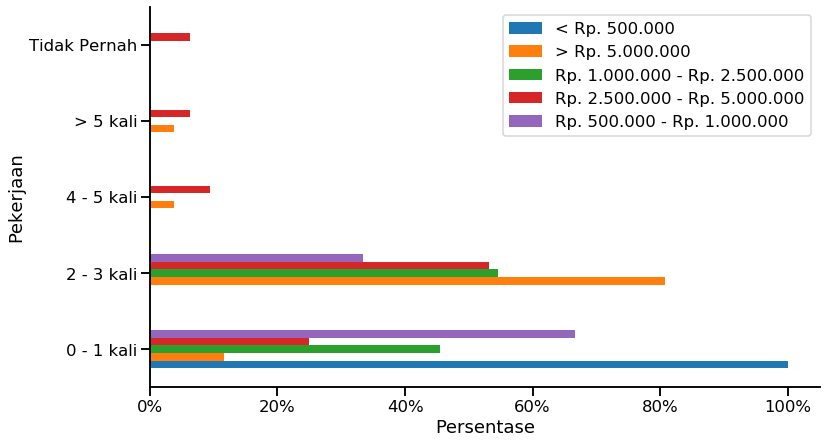

In [251]:
pivoted = dfb[dfb['bekerja'] != 'other'].pivot_table(
    values = 'Jenis kelamin',
    index = 'Pengeluaran yang Anda keluarkan selama 1 bulan',
    columns = 'Dalam seminggu, seberapa sering Anda mengonsumsi Produk Perikanan?',
    aggfunc = 'count',
    fill_value = 0
)
ax = pivoted.divide(pivoted.sum(axis=1), axis=0).T.plot.barh()
plt.legend()
vals = ax.get_xticks()
ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])
plt.xlabel('Persentase')
plt.ylabel('Pekerjaan')
sns.despine()

Menariknya disini semakin tinggi pengeluaran justru lebih sering mengonsumsi ikan!

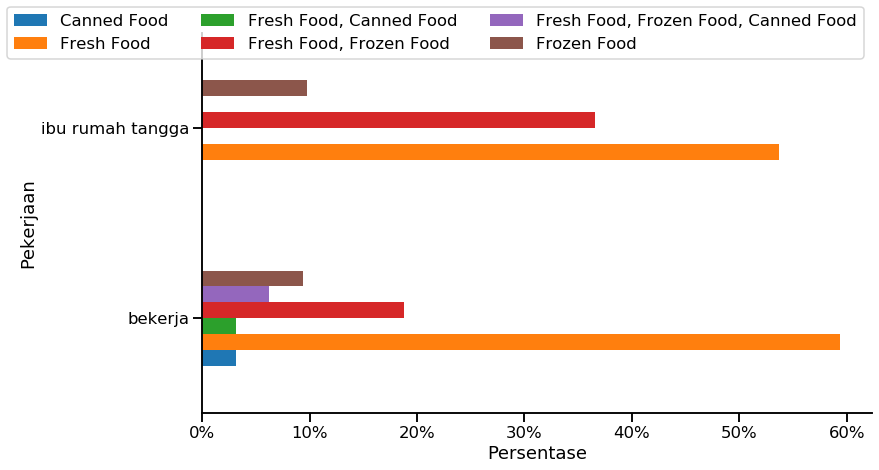

In [253]:
pivoted = dfb[dfb['bekerja'] != 'other'].pivot_table(
    values = 'Jenis kelamin',
    index = ['Jenis pengolahan ikan yang Anda minati'],
    columns = ['bekerja'],
    aggfunc = 'count',
    fill_value = 0
)
ax = pivoted.divide(pivoted.sum(axis=0), axis=1).T.plot.barh()
plt.legend(
    loc='right',
    bbox_to_anchor=(1,1),
    ncol=3
)
vals = ax.get_xticks()
ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])
plt.xlabel('Persentase')
plt.ylabel('Pekerjaan')
sns.despine()

Ibu rumah tangga lebih memilih fresh food, atau kombinasi fresh food dan frozen food
Responden yang bekerja seperti terbagi dua yang wajib fresh atau terbuka dengan opsi frozen maupun canned.
Sebetulnya tentang keinstantan ini lebih bagus lagi jika mencoba ekplorasi kolom 'Apa yang mempengaruhi keputusan Anda memilih Produk Ikan beku' dan 'Jenis produk ikan beku yang paling Anda minati'

Tapi saya belum mengerti cara untuk memisahkan dan mengelompokkan variabel yang kombinasi nya terlalu banyak

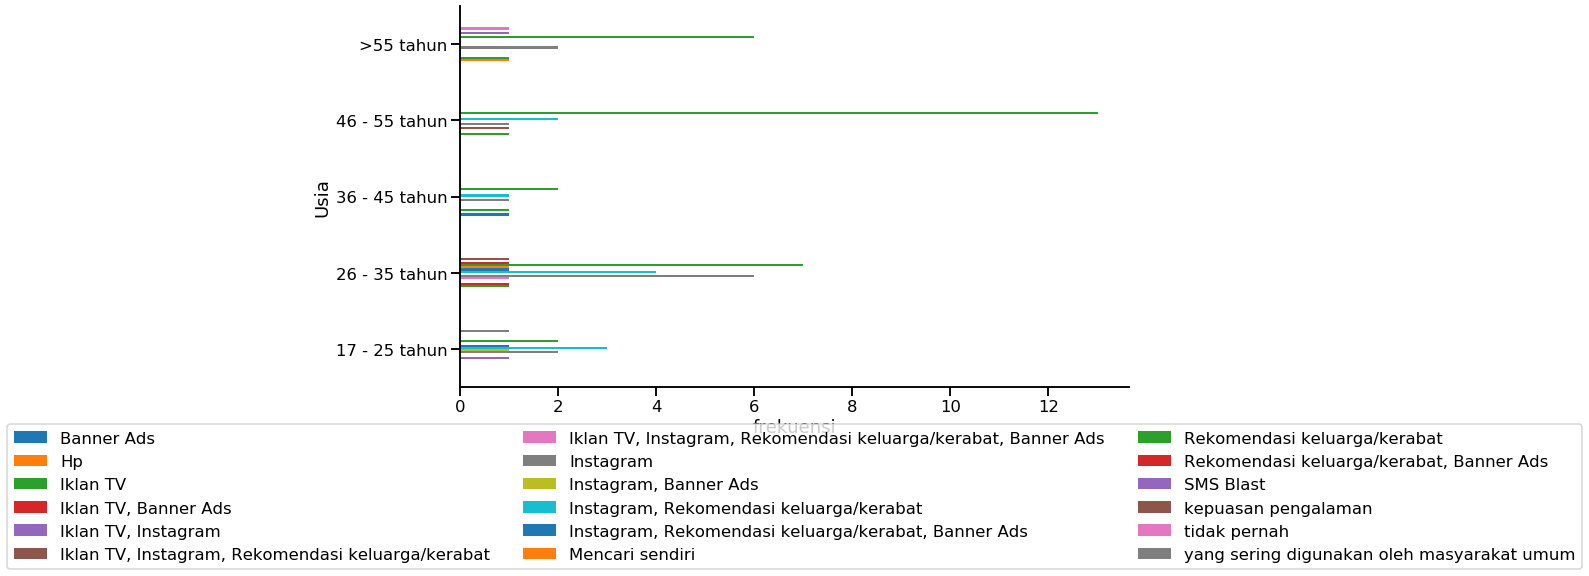

In [176]:
dfb[dfb['bekerja'] != 'other'].pivot_table(
    values = 'Jenis kelamin',
    index = ['Darimana Anda mendapatkan Referensi channel Marketplace/ E-Commerce'],
    columns = ['Usia'],
    aggfunc = 'count',
    fill_value = 0
).T.plot.barh()
plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=3
)
plt.xlabel('frekuensi')
sns.despine()